<a href="https://colab.research.google.com/github/BenShieh233/NLP-Text-Mining/blob/main/IC10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn import preprocessing
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

import matplotlib
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Exploratory Data Analysis

In [66]:
clinical_text_df = pd.read_csv('/content/drive/MyDrive/INFOSYS765/mts_data.csv')
clinical_text_df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,2366,"This patient has undergone cataract surgery, ...",Ophthalmology,YAG Laser Capsulotomy - 1,"PREOPERATIVE DIAGNOSIS: , Secondary capsular m...","ophthalmology, abraham capsulotomy, yag, yag l..."
1,2368,Combined closed vitrectomy with membrane peel...,Ophthalmology,Vitrectomy - 1,"PREOPERATIVE DIAGNOSIS: , Vitreous hemorrhage ...","ophthalmology, vitreous hemorrhage, retinal de..."
2,2369,Visually significant posterior capsule opacit...,Ophthalmology,YAG Laser Capsulotomy,"PREOPERATIVE DIAGNOSIS:, Visually significant...","ophthalmology, capsule opacity, yag, ophthalmi..."
3,2370,Vitrectomy under local anesthesia.,Ophthalmology,Vitrectomy - Local Anesthesia,"DESCRIPTION OF PROCEDURE:, After appropriate ...","ophthalmology, lid speculum, conjunctival, per..."
4,2371,"Vitreous hemorrhage, right eye. Vitrectomy, ...",Ophthalmology,Vitrectomy,"PREOPERATIVE DIAGNOSIS:, Vitreous hemorrhage,...","ophthalmology, ophthalmoscopic, vitrectomy, en..."


In [67]:
# Get unique word and sentence count in a list of text
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [68]:
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 63584
Number of unique words in transcriptions column: 29012
===========Original Categories =======================
Cat:1  Ophthalmology : 83
Cat:2  Orthopedic : 355
Cat:3  Pain Management : 61
Cat:4  Pediatrics - Neonatal : 70
Cat:5  Physical Medicine - Rehab : 21
Cat:6  Podiatry : 47
Cat:7  Psychiatry / Psychology : 53
Cat:8  Radiology : 273
Cat:9  Rheumatology : 10
Cat:10  SOAP / Chart / Progress Notes : 166
Cat:11  Sleep Medicine : 20
Cat:12  Speech - Language : 9
Cat:13  Surgery : 1088
Cat:14  Urology : 156


In [69]:
# Remove some categories that have less than 50 samples
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

============Reduced Categories ======================
Cat:1  Ophthalmology : 83
Cat:2  Orthopedic : 355
Cat:3  Pain Management : 61
Cat:4  Pediatrics - Neonatal : 70
Cat:5  Psychiatry / Psychology : 53
Cat:6  Radiology : 273
Cat:7  SOAP / Chart / Progress Notes : 166
Cat:8  Surgery : 1088
Cat:9  Urology : 156
============ Reduced Categories ======================


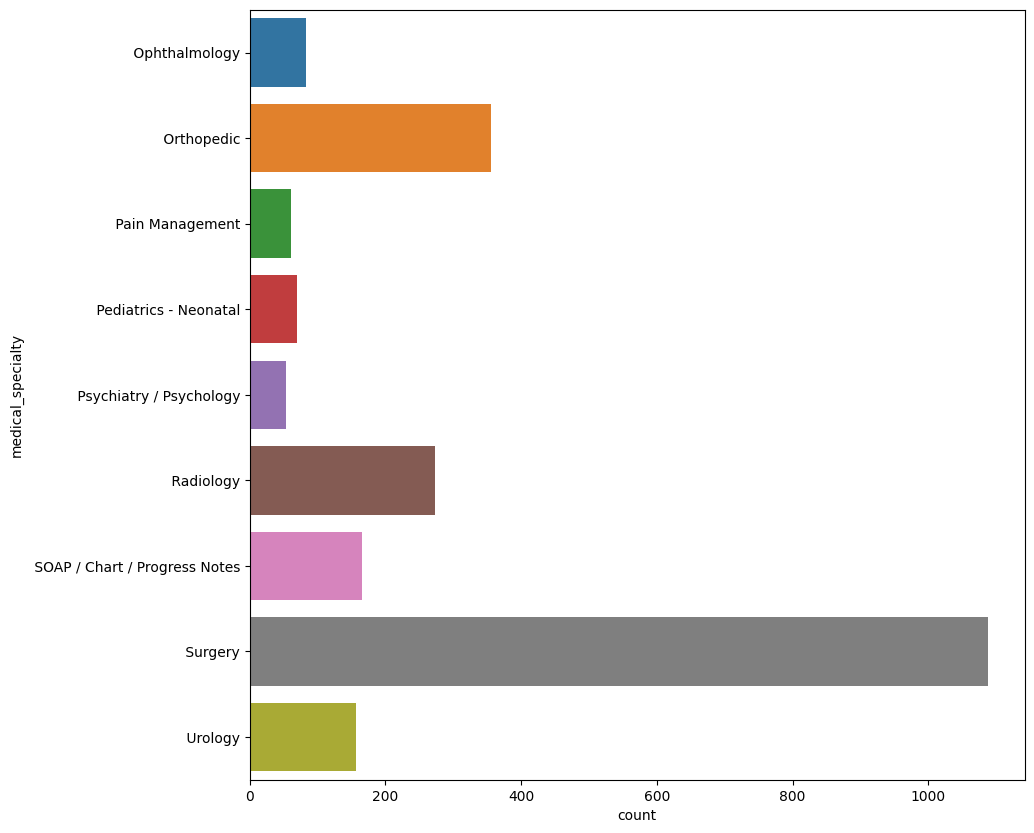

In [70]:
# Plot the categories
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

In [71]:
# Focus only on the 'transcription' and 'medical_specialty' columns in the dataset
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(2305, 2)

In [72]:
# Define methods for data cleaning
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

In [73]:
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [74]:
# Perform TfidfVectorizer to generate tf-idf features
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen pelvis', 'abdominal', 'abdominal pain', 'abnormal', 'abscess', 'activity', 'acute', 'adenocarcinoma', 'adequate', 'administered', 'admission', 'admitted', 'africanamerican', 'age', 'ago', 'airway', 'alternative', 'anesthesia', 'anesthesia care', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia local', 'anesthesia local sedation', 'anesthesia monitored', 'anesthesia monitored anesthesia', 'anesthesia patient', 'anesthesia spinal', 'anesthesia wa', 'anesthetic', 'ankle', 'anterior', 'anterior cervical', 'anterior cervical discectomy', 'antibiotic', 'aortic', 'ap', 'apparent', 'appendicitis', 'applied', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'arthroplasty', 'asked', 'aspect', 'assessment', 'associated', 'atrial', 'awakened', 'axial', 'axial ct', 'axis', 'baby', 'base', 'benefit', 'benign', 'better', 'bilateral', 'bilaterally', 'biopsy', 'bipolar', 'bladder', 'bladder tumor', 'bleeding'

### 1. Use logistics regression without using any dimention reduction technique

In [75]:
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat, labels, stratify=labels,random_state=1)

In [76]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1728, 1000)
Test_Set_Size:(577, 1000)


Use Logistics Regression to learn on training data and predict on test data

In [77]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

In [78]:
# Visualize the confusion matrix and the classification results
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

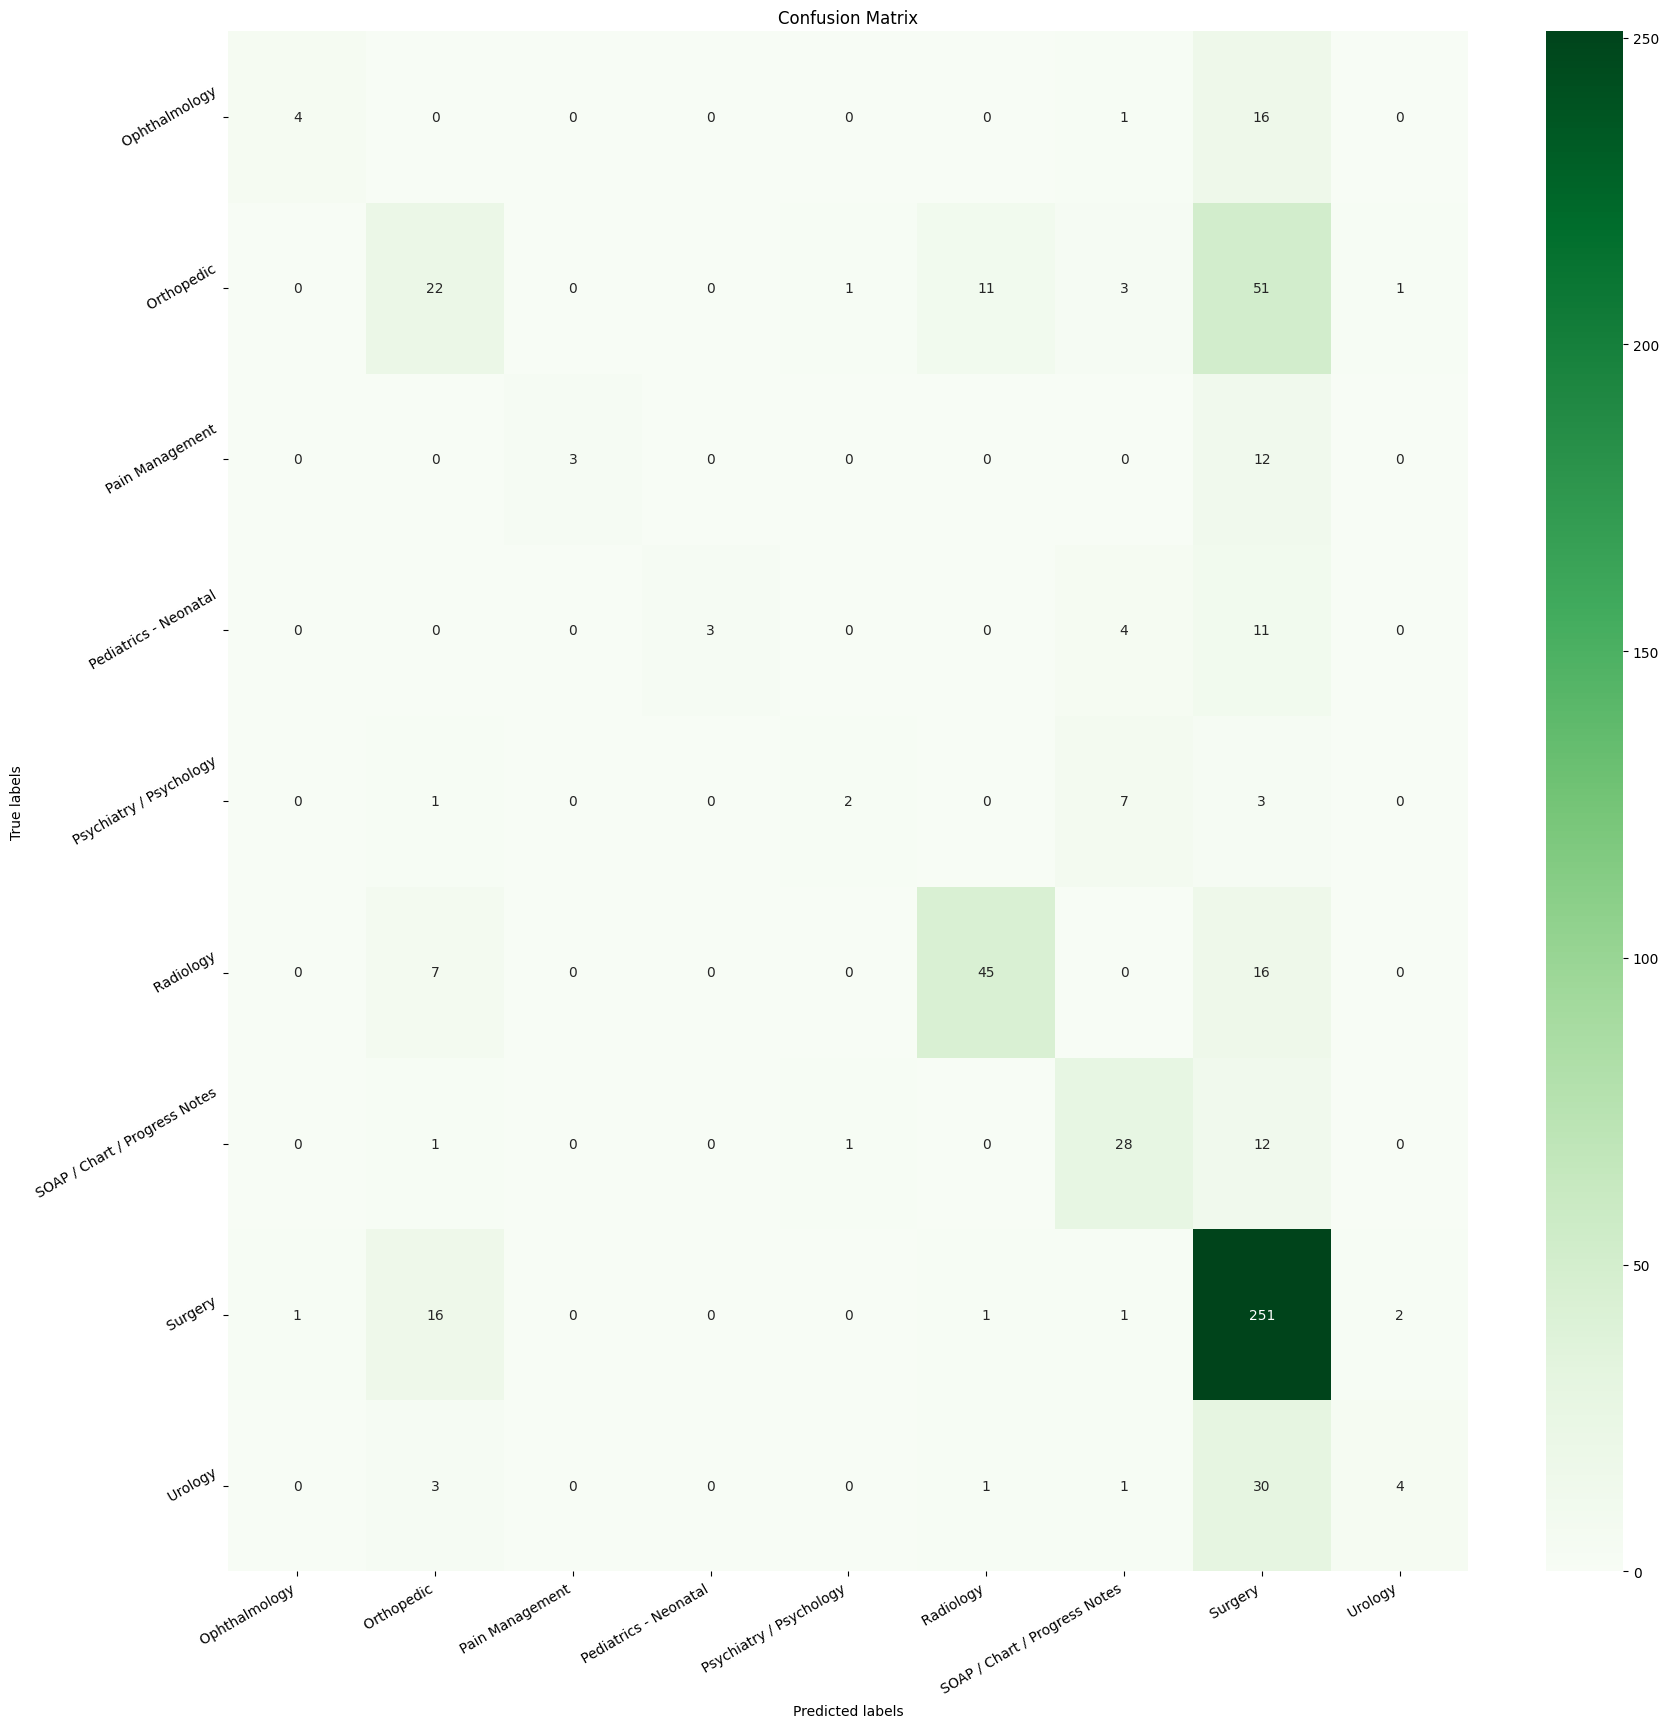

In [79]:
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [28]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                                precision    recall  f1-score   support

                 Ophthalmology       0.80      0.19      0.31        21
                    Orthopedic       0.44      0.25      0.32        89
               Pain Management       1.00      0.20      0.33        15
         Pediatrics - Neonatal       1.00      0.17      0.29        18
       Psychiatry / Psychology       0.50      0.15      0.24        13
                     Radiology       0.78      0.66      0.71        68
 SOAP / Chart / Progress Notes       0.62      0.67      0.64        42
                       Surgery       0.62      0.92      0.74       272
                       Urology       0.57      0.10      0.17        39

                      accuracy                           0.63       577
                     macro avg       0.70      0.37      0.42       577
                  weighted avg       0.64      0.63      0.58       577



The macro average F1-score of the initial classification model is 0.42. Among all medical specialties, *`Radiology`* (0.71), *`Surgery`* (0.74), and *`SOAP / Chart / Progress Notes`* (0.64) are the top three specialties that the initial model displays relatively higher predictive performance in terms of F1-scores. 

### 2. Modify the initial model (1) by adding the PCA componnet in the data preparation

In [82]:
import gc
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)   

In [83]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1728, 525)
Test_Set_Size:(577, 525)


In [85]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

In [86]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

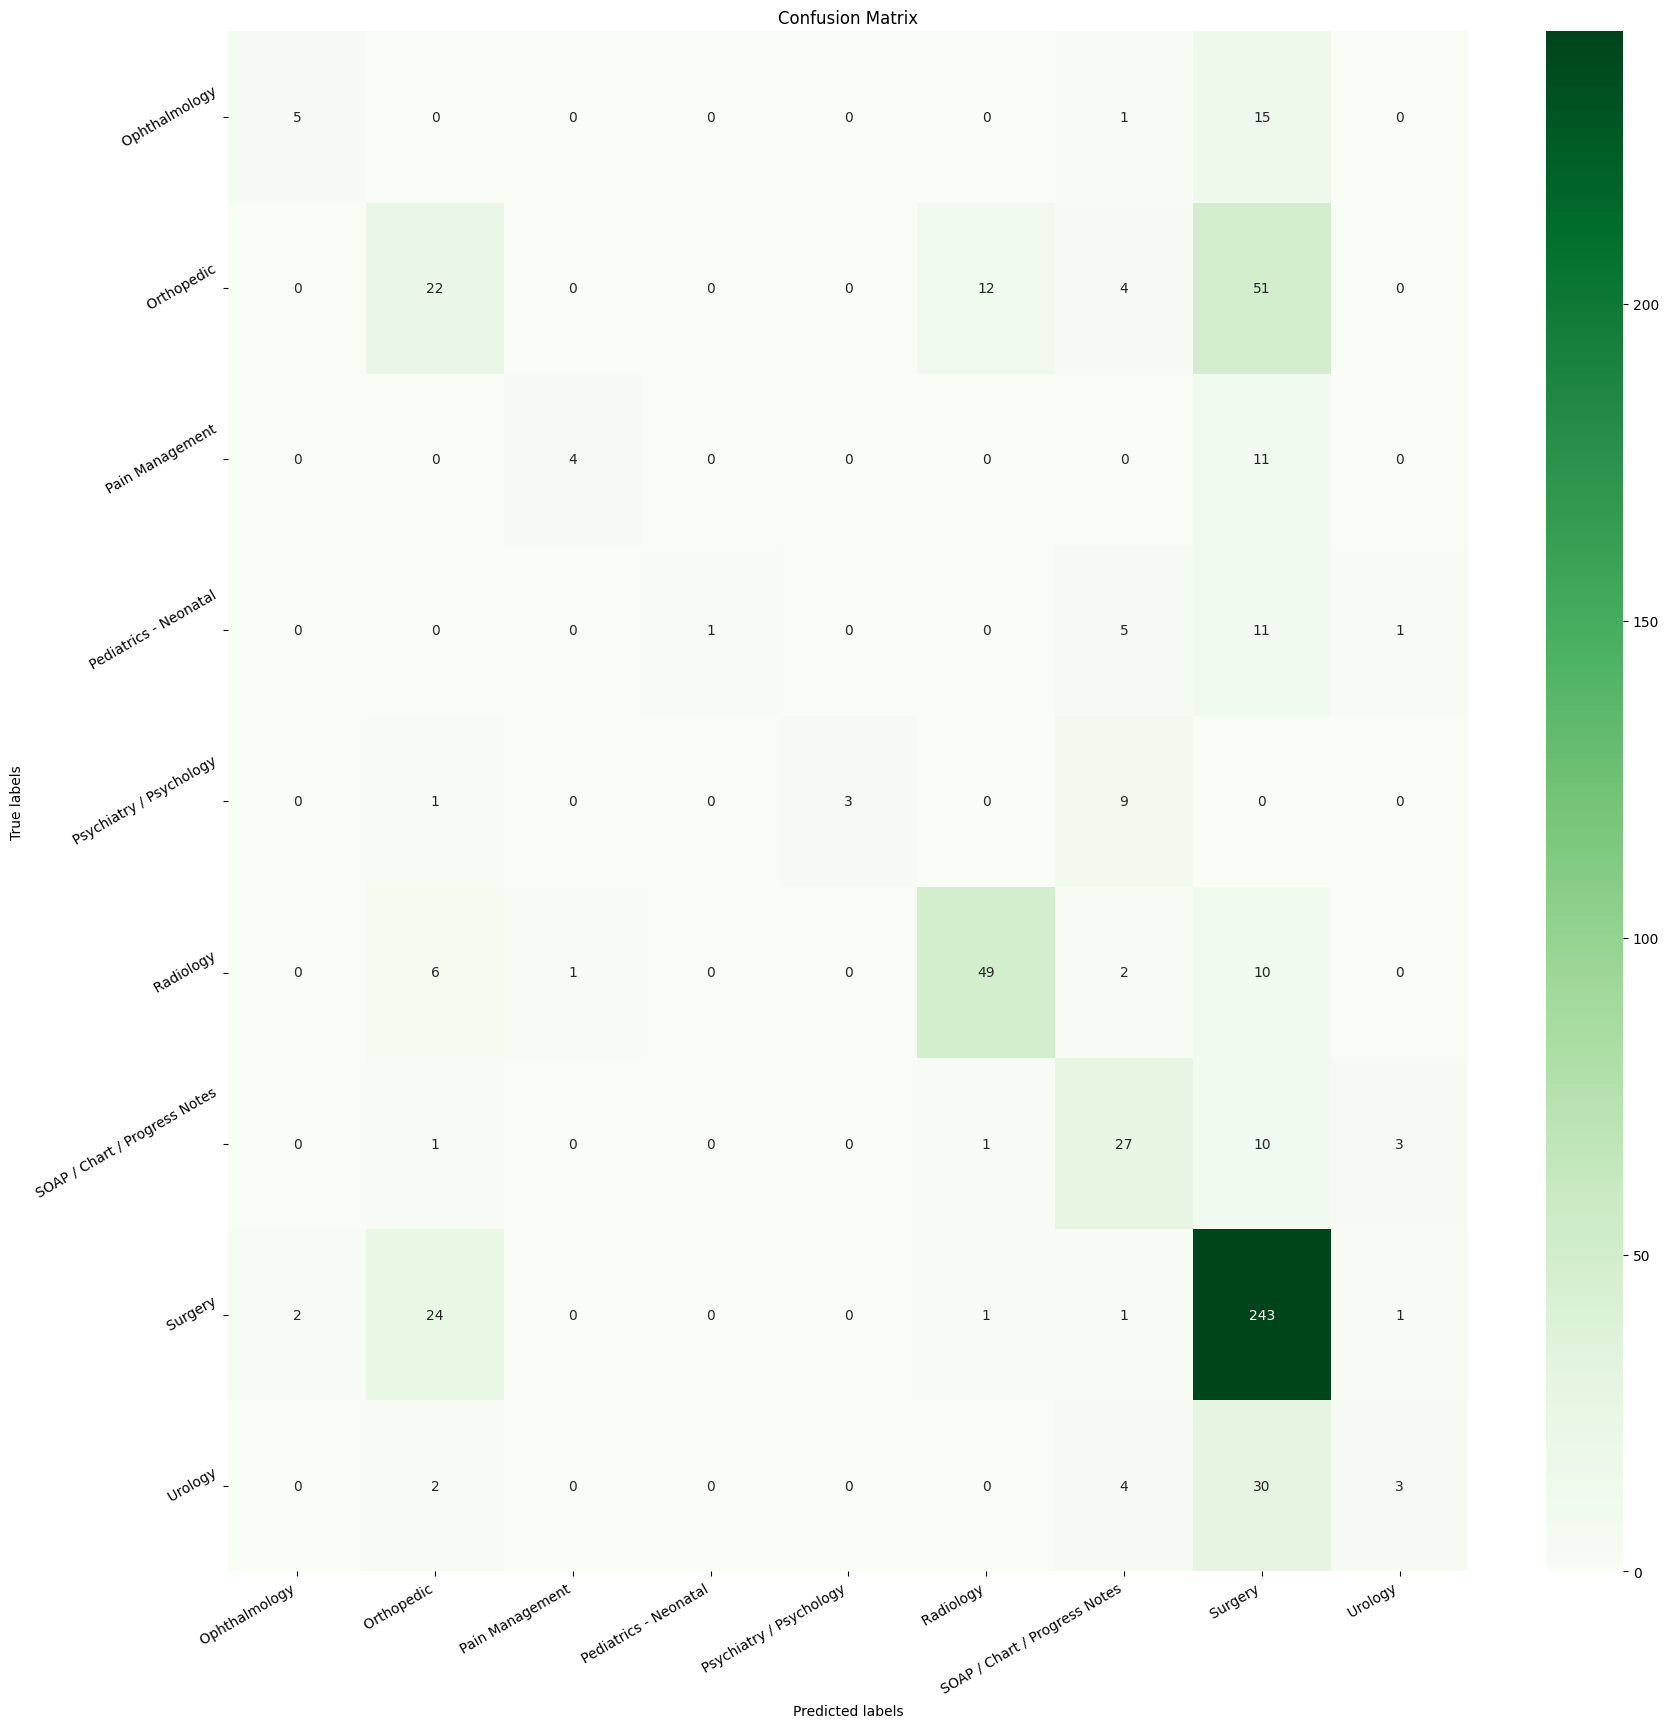

In [87]:
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [88]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                                precision    recall  f1-score   support

                 Ophthalmology       0.71      0.24      0.36        21
                    Orthopedic       0.39      0.25      0.30        89
               Pain Management       0.80      0.27      0.40        15
         Pediatrics - Neonatal       1.00      0.06      0.11        18
       Psychiatry / Psychology       1.00      0.23      0.38        13
                     Radiology       0.78      0.72      0.75        68
 SOAP / Chart / Progress Notes       0.51      0.64      0.57        42
                       Surgery       0.64      0.89      0.74       272
                       Urology       0.38      0.08      0.13        39

                      accuracy                           0.62       577
                     macro avg       0.69      0.37      0.41       577
                  weighted avg       0.62      0.62      0.57       577



PCA does not improve the macro average F1-score in the initial model. Instead, it is reduced from 0.42 to 0.41, leading to a poor performance. But the F1-score of the specialty *`Radiology`* (0.75) has been improved while the F1-score of *`SOAP / Chart / Progress Notes`* (0.57) has been reduced.

### 3. Optimize the classification model by performing necessary data transformations.

<b>Combine several similar categories.

In [89]:
filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]


mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'

In [90]:
i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

============Reduced Categories======================
Cat:1 Ophthalmology : 83
Cat:2 Orthopedic : 355
Cat:3 Pain Management : 61
Cat:4 Pediatrics - Neonatal : 70
Cat:5 Psychiatry / Psychology : 53
Cat:6 Radiology : 273
Cat:7 SOAP / Chart / Progress Notes : 166
Cat:8 Urology : 156
============Reduced Categories======================


(990, 2)

<b> Use SciSpacy to detect medical entities in the transcription.

In [46]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 MB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 84.8 MB/s eta 0:00:00
  Created wheel for en-ner-bionlp13cg-md: filename=en_ner_bionlp13cg_md-0.5.1-py3-none-any.whl size=120241159 sha256=1be4e4233134b9d4b0e0b7fabd18cb7a727ad5c998f9fced47515fc64aa86035
  Stored in directory: /root/.cache/pip/wheels/a6/ff/ad/3c05d07fc5817177eedcc32e5cf5774fd6d07b58d54caaa76d
Successfully built en-ner-bionlp13cg-md
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.1
    Uninstalling spacy-3.5.1:
      Successfully uninstalled spacy-3.5.1
ERROR: pip's dependency resolver does not currently take into account a

In [91]:
import spacy
import en_ner_bionlp13cg_md
nlp = en_ner_bionlp13cg_md.load()

In [92]:
def process_Text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)     

In [93]:
data['transcription'] = data['transcription'].apply(process_Text)
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [95]:
data.shape

(990, 2)

In [96]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[989]['transcription'])

Sample Transcription 1:patient endotracheal patient eye eye conjunctival peritomy limbus line inferotemporal quadrant superonasal superotemporal quadrant eye

Sample Transcription 2:

Sample Transcription 3:adrenal adrenal umbilical left umbilical general  clinical umbilicus umbilical midline midaxillary line costal margin liver colon liver adrenal kidney liver vena cava renal vein renal vein vena cava small vessel kidney tumor kidney adrenal adrenal vein adrenal artery umbilical fascia blood patient


<b> Extract tf-idf features then perform dimensionality reduction on the feature using t-sne and plot the t-sne features.

In [97]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['abdomen', 'abdomen pelvis', 'abdominal', 'abds', 'abds patient', 'abductor', 'acl', 'acute', 'adenocarcinoma', 'adenosine', 'adhesion', 'adipose', 'adipose space', 'adrenal', 'adrenal gland', 'air', 'air cell', 'airway', 'albuterol', 'alcohol', 'alcohol patient', 'allograft', 'amniotic', 'amniotic fluid', 'anesthesia', 'anesthesia patient', 'annular', 'antebrachial', 'antebrachial fascia', 'anterior', 'anterior anterior', 'anterior border', 'anterior cervical', 'anterior chamber', 'anterior chamber anterior', 'anterior chamber corneal', 'anterior chamber eye', 'anterior chamber wound', 'anterior cruciate', 'anterior fontanelle', 'anterior posterior', 'anterolateral', 'aorta', 'aortic', 'aortic valve', 'ap', 'ap lateral', 'apex', 'apical', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery left', 'artery patient', 'articular', 'articular cartilage', 'articular surface', 'aspirin', 'atrial', 'atrium', 'axillary', 'axis', 'bacitracin', 'base', 'bed', 'benign', 'betadine', 'biceps', 'b

In [98]:
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()

<b> Split the train and test sets and use logistics regression for developing a classification model and then visualize the results.

In [99]:
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(742, 441)
Test_Set_Size:(248, 441)


In [100]:
#clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

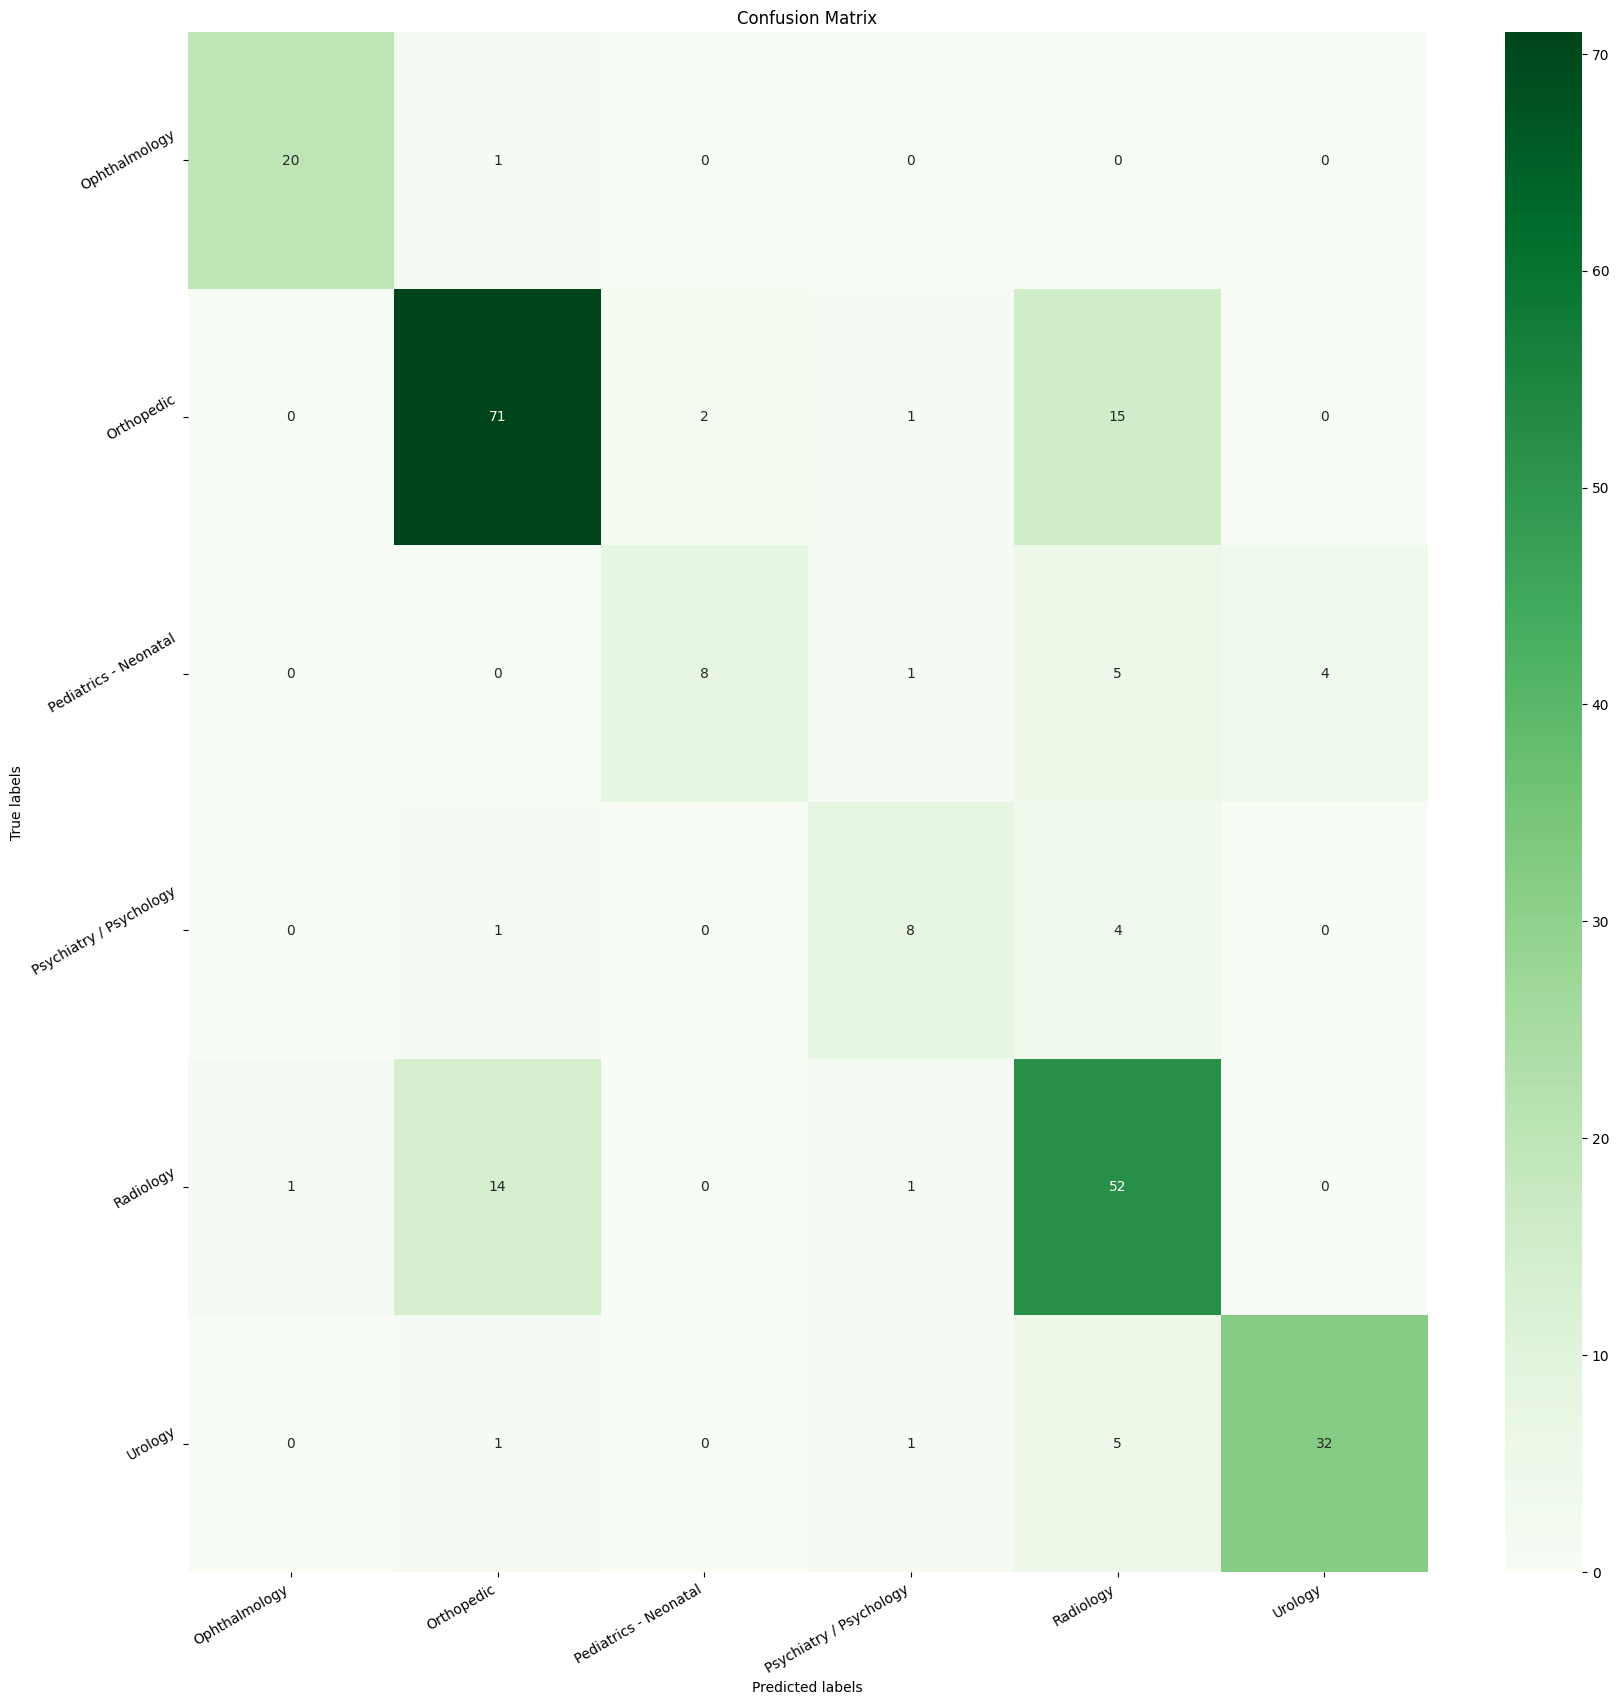

                         precision    recall  f1-score   support

          Ophthalmology       0.95      0.95      0.95        21
             Orthopedic       0.81      0.80      0.80        89
  Pediatrics - Neonatal       0.80      0.44      0.57        18
Psychiatry / Psychology       0.67      0.62      0.64        13
              Radiology       0.64      0.76      0.70        68
                Urology       0.89      0.82      0.85        39

               accuracy                           0.77       248
              macro avg       0.79      0.73      0.75       248
           weighted avg       0.78      0.77      0.77       248



In [101]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

There is significant improvement on the macro average F1-score which has been raised to 0.75. Also the individual F1-score of each specialty has rose significantly compared to the previous classification models.

### 4. Use the Synesthetic Minority Over-sampling Technique to generate more samples from the minority classes.

<b> Use SMOTE to generate more sample from minority class to solve the data imbalance problem.

In [102]:
smote_over_sample = SMOTE(sampling_strategy='minority')
labels = data['medical_specialty'].tolist()
X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(969, 441)
Test_Set_Size:(323, 441)


In [103]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

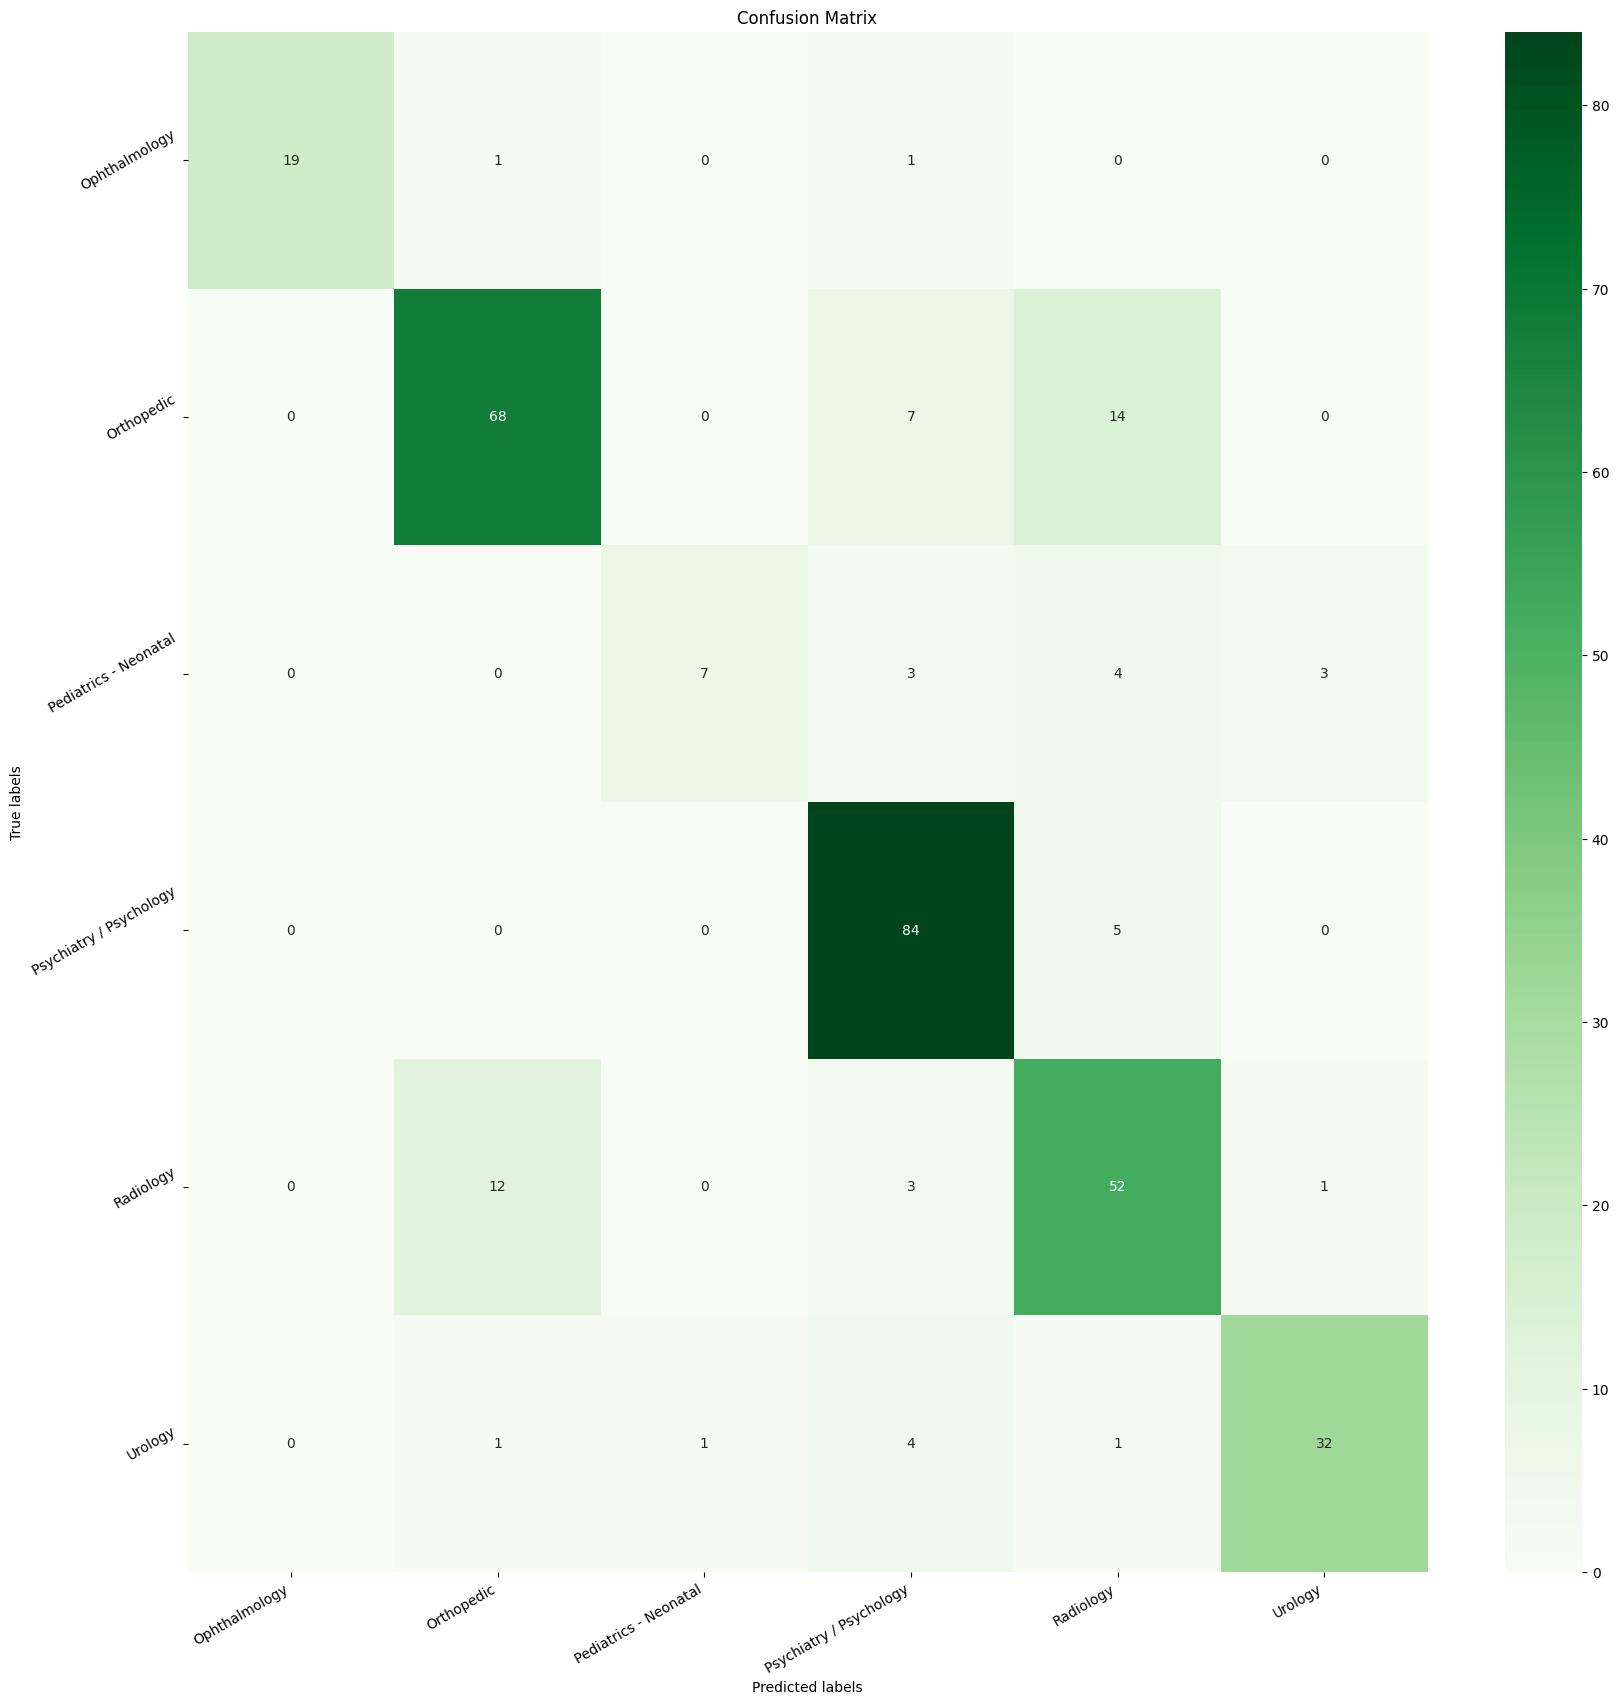

                         precision    recall  f1-score   support

          Ophthalmology       1.00      0.90      0.95        21
             Orthopedic       0.83      0.76      0.80        89
  Pediatrics - Neonatal       0.88      0.41      0.56        17
Psychiatry / Psychology       0.82      0.94      0.88        89
              Radiology       0.68      0.76      0.72        68
                Urology       0.89      0.82      0.85        39

               accuracy                           0.81       323
              macro avg       0.85      0.77      0.79       323
           weighted avg       0.82      0.81      0.81       323



In [104]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))


*Summary*
There is further improvement on the macro average F1-score of the classification model (0.79). The individual specialties's F1-scores have also been rasied to their highest values so far.

### 5. Review results from (2) - (4). 

The fourth change givews me the largest improvement (0.79) in classification performance, which applies SMOTE to balance the data. 

### 6. What are the remaining issues in the classification.

Some categoreis such as *`Pediatrics - Neonatal`* and *`Radiology`* are not correctly classified.

<b> How to improve the model further.

In [108]:
mask = filtered_data_categories['medical_specialty'] == 'Radiology'
radiologyData = filtered_data_categories[mask]
print(radiologyData['transcription'].tolist()[1])

EXAM: , Two views of the soft tissues of the neck.,HISTORY:,  Patient has swelling of the left side of his neck.,TECHNIQUE:,  Frontal and lateral views of the soft tissues of the neck were evaluated. There were no soft tissues of the neck radiographs for comparison. However, there was an ultrasound of the neck performed on the same day.,FINDINGS: , Frontal and lateral views of the soft tissues of the neck were evaluated and reveal there is an asymmetry seen to the left-sided soft tissues of the patient's neck which appear somewhat enlarged when compared to patient's right side. However the trachea appears to be normal caliber and contour.  Lateral views show a patent airway. The adenoids and tonsils appear normal caliber without evidence of hypertrophy. Airway appears patent. Osseous structures appear grossly normal.,IMPRESSION:,1. Patent airway. No evidence of any soft tissue swelling involving the patient's adenoids/tonsils, epiglottis or aryepiglottic folds. No evidence of any preve

In [109]:
mask = clinical_text_df['medical_specialty'] ==  ' Pediatrics - Neonatal'
pediaData = clinical_text_df[mask]
print(pediaData ['transcription'].tolist()[1])

SUBJECTIVE:,  Patient presents with Mom and Dad for her 5-year 3-month well-child check.  Family has not concerns stating patient has been doing well overall since last visit.  Taking in a well-balanced diet consisting of milk and dairy products, fruits, vegetables, proteins and grains with minimal junk food and snack food.  No behavioral concerns.  Gets along well with peers as well as adults.  Is excited to start kindergarten this upcoming school year.  Does attend daycare.  Normal voiding and stooling pattern.  No concerns with hearing or vision.  Sees the dentist regularly.  Growth and development:  Denver II normal passing all developmental milestones per age in areas of fine motor, gross motor, personal and social interaction and speech and language development.  See Denver II form in the chart.,ALLERGIES:,  None.,MEDICATIONS: , None.,FAMILY SOCIAL HISTORY:,  Unchanged since last checkup.  Lives at home with mother, father and sibling.  No smoking in the home.,REVIEW OF SYSTEMS:,

Some learnings from this dataset are:

This dataset is very noisy. Lot of text in transcriptions overlaps across categories. We can apply domain knowledge to reduce the categories.

Hand coded features may improve results on this dataset but may not apply to generic transcription datasets.